In [2]:
# Loading all Modules #
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
import pandas as pd
from deepxde.backend import tf
from scipy import interpolate
print(tf.__version__)

Deepxde backend not selected or invalid. Assuming tensorflow.compat.v1 for now.
Using backend: tensorflow.compat.v1



Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDEBACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch (all lowercase)
Instructions for updating:
non-resource variables are not supported in the long term

2.7.0


In [197]:
# Setting non-dimensional parameters based on experimental data #

del_stress = 40.0-9.0 #70-10
stress_min = 9.0  
del_time = 9.858-0.031
time_min = 0.031
del_shear_rate = 0.102-0.05 #0.202 
shear_min = 0.05

# Generating training data by reading excel files #

def gen_training_data():
    
    time_data = []
    gammadot_data = []
    shear_stress_data = []
    
    for itr in range(0,5): 
        if itr==2: # skipping shear rate of 0.08/s from giving as training data so the prediction can be checked later
            continue
        t_expt = []
        t_expt_first = []
        t_expt_last = []
        gammadot = []
        gammadot_first = []
        gammadot_last = []
        shear_stress = []
        shear_stress_first = []
        shear_stress_last = []
        t_fitted = []
        gammadot_fitted = []
        shear_stress_fitted = []
       
        startUpFlow = pd.read_excel('DOW1_030323.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=itr, skiprows=range(155,298)) 
        # Reading data from sheet number - itr
        t_expt = np.array(startUpFlow["t"])
        t_expt_first = t_expt[0:54]
        t_expt_last = t_expt[54:]
        print(t_expt_first)
        print(t_expt_last)
        
        gammadot = np.array(startUpFlow["shear rate"])
        gammadot_first = gammadot[0:54]
        gammadot_last = gammadot[54:]
        
        shear_stress = np.array(startUpFlow["shear stress"])
        shear_stress_first = shear_stress[0:54]
        shear_stress_last = shear_stress[54:]
        
        # interpolating shear stress and shear rate separately with time (increasing data points)
        f_shear_stress = interpolate.interp1d(t_expt_first, shear_stress_first) 
        f_gammadot = interpolate.interp1d(t_expt_first, gammadot_first)
        t_fitted = np.linspace(t_expt_first[0],t_expt_first[t_expt_first.size-1],50)  #150 
        gammadot_fitted = f_gammadot(t_fitted)
        shear_stress_fitted = f_shear_stress(t_fitted) 
        
        f_shear_stress_1 = interpolate.interp1d(t_expt_last, shear_stress_last) 
        f_gammadot_1 = interpolate.interp1d(t_expt_last, gammadot_last)
        t_fitted_1 = np.linspace(t_expt_last[0],t_expt_last[t_expt_last.size-1], 50)   #100
        gammadot_fitted_1 = f_gammadot_1(t_fitted_1)
        shear_stress_fitted_1 = f_shear_stress_1(t_fitted_1)
        
        time_itr = []
        gammadot_itr = []
        shear_stress_itr = []
        
        time_itr = np.append(t_fitted,t_fitted_1)
        time_itr = time_itr[:,np.newaxis]
        
        gammadot_itr = np.append(gammadot_fitted,gammadot_fitted_1)
        gammadot_itr = gammadot_itr[:,np.newaxis] 
        
        shear_stress_itr = np.append(shear_stress_fitted,shear_stress_fitted_1)
        shear_stress_itr = shear_stress_itr[:,np.newaxis]
        
        plt.plot(time_itr,shear_stress_itr, '-r', label='Fit')
        plt.plot(t_expt,shear_stress,'*b', label='Experiment')
        plt.legend()
        plt.xscale('log')

        plt.xlabel('time (s)')
        plt.ylabel('Shear stress (Pa)')
        plt.show()
        
        # Non-Dimensionalizing - O(0-1)
        time_itr =  (t_expt-time_min)/(del_time)  
        gammadot_itr =  (gammadot-shear_min)/(del_shear_rate)          
        shear_stress_itr = (shear_stress-stress_min)/(del_stress) 
        
        # Appending data from each sheet to a global array and converting to a column
        
        time_data = np.append(time_data,time_itr)
        time_data = time_data[:,np.newaxis]
        
        gammadot_data = np.append(gammadot_data,gammadot_itr)
        gammadot_data = gammadot_data[:,np.newaxis] 
        
        shear_stress_data = np.append(shear_stress_data,shear_stress_itr)
        shear_stress_data = shear_stress_data[:,np.newaxis]
    
        print(np.size(gammadot_data))
        print(np.size(time_data))   
        print(np.size(shear_stress_data))
    
    
    return np.hstack((gammadot_data, time_data)) , shear_stress_data 
    

[0.031 0.042 0.052 0.063 0.075 0.086 0.098 0.11  0.122 0.134 0.147 0.159
 0.173 0.186 0.199 0.213 0.227 0.242 0.256 0.271 0.286 0.302 0.318 0.334
 0.35  0.367 0.384 0.402 0.419 0.437 0.456 0.474 0.494 0.513 0.533 0.553
 0.574 0.595 0.616 0.638 0.661 0.683 0.706 0.73  0.754 0.779 0.804 0.829
 0.855 0.881 0.908 0.936 0.964 0.992]
[1.022 1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381
 1.418 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87
 1.916 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484
 2.542 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257
 3.329 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228
 4.319 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449
 5.564 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984
 7.128 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914
 9.096 9.281 9.469 9.662 9.858]


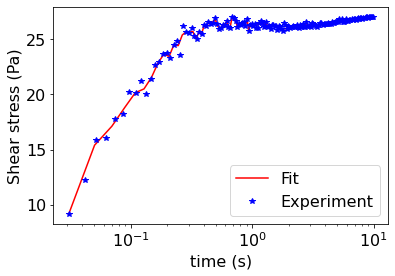

155
155
155
[0.031 0.042 0.052 0.063 0.075 0.086 0.098 0.11  0.122 0.134 0.147 0.159
 0.173 0.186 0.199 0.213 0.227 0.242 0.256 0.271 0.286 0.302 0.318 0.334
 0.35  0.367 0.384 0.402 0.419 0.437 0.456 0.474 0.494 0.513 0.533 0.553
 0.574 0.595 0.616 0.638 0.661 0.683 0.706 0.73  0.754 0.779 0.804 0.829
 0.855 0.881 0.908 0.936 0.964 0.992]
[1.022 1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381
 1.418 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87
 1.916 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484
 2.542 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257
 3.329 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228
 4.319 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449
 5.564 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984
 7.128 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914
 9.096 9.281 9.469 9.662 9.858]


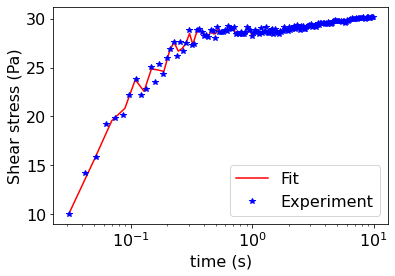

310
310
310
[0.031 0.042 0.052 0.063 0.075 0.086 0.098 0.11  0.122 0.134 0.147 0.159
 0.173 0.186 0.199 0.213 0.227 0.242 0.256 0.271 0.286 0.302 0.318 0.334
 0.35  0.367 0.384 0.402 0.419 0.437 0.456 0.474 0.494 0.513 0.533 0.553
 0.574 0.595 0.616 0.638 0.661 0.683 0.706 0.73  0.754 0.779 0.804 0.829
 0.855 0.881 0.908 0.936 0.964 0.992]
[1.022 1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381
 1.418 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87
 1.916 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484
 2.542 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257
 3.329 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228
 4.319 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449
 5.564 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984
 7.128 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914
 9.096 9.281 9.469 9.662 9.858]


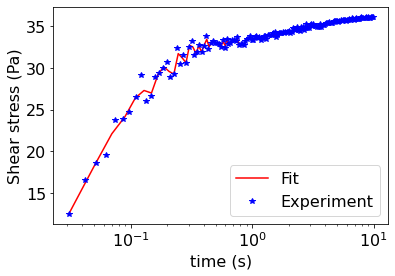

465
465
465
[0.031 0.042 0.052 0.063 0.075 0.086 0.098 0.11  0.122 0.134 0.147 0.159
 0.173 0.186 0.199 0.213 0.227 0.242 0.256 0.271 0.286 0.302 0.318 0.334
 0.35  0.367 0.384 0.402 0.419 0.437 0.456 0.474 0.494 0.513 0.533 0.553
 0.574 0.595 0.616 0.638 0.661 0.683 0.706 0.73  0.754 0.779 0.804 0.829
 0.855 0.881 0.908 0.936 0.964 0.992]
[1.022 1.051 1.081 1.112 1.144 1.176 1.208 1.242 1.275 1.31  1.345 1.381
 1.418 1.455 1.493 1.532 1.571 1.611 1.653 1.694 1.737 1.78  1.825 1.87
 1.916 1.963 2.011 2.059 2.109 2.159 2.211 2.264 2.317 2.372 2.427 2.484
 2.542 2.601 2.661 2.722 2.785 2.848 2.913 2.979 3.047 3.115 3.185 3.257
 3.329 3.404 3.479 3.556 3.635 3.715 3.796 3.879 3.964 4.05  4.138 4.228
 4.319 4.412 4.507 4.604 4.703 4.803 4.906 5.01  5.117 5.225 5.336 5.449
 5.564 5.681 5.8   5.922 6.046 6.173 6.301 6.433 6.567 6.703 6.842 6.984
 7.128 7.276 7.426 7.579 7.735 7.894 8.056 8.221 8.389 8.561 8.736 8.914
 9.096 9.281 9.469 9.662 9.858]


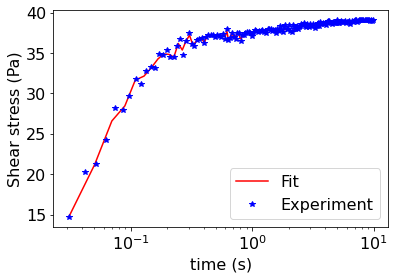

620
620
620
[[5.19230769e-02 6.01601466e-16]
 [1.82692308e-01 1.11936501e-03]
 [1.80769231e-01 2.13696957e-03]
 ...
 [9.61538462e-01 9.60415183e-01]
 [9.61538462e-01 9.80054951e-01]
 [9.61538462e-01 1.00000000e+00]]
[[0.00454839]
 [0.10529032]
 [0.22274194]
 [0.22777419]
 [0.28448387]
 [0.29658065]
 [0.36129032]
 [0.35993548]
 [0.39406452]
 [0.35512903]
 [0.39890323]
 [0.44029032]
 [0.45029032]
 [0.47219355]
 [0.4753871 ]
 [0.46048387]
 [0.49987097]
 [0.51196774]
 [0.47016129]
 [0.55532258]
 [0.53783871]
 [0.53341935]
 [0.54977419]
 [0.52641935]
 [0.51583871]
 [0.53848387]
 [0.53174194]
 [0.55851613]
 [0.55458065]
 [0.56722581]
 [0.56016129]
 [0.56470968]
 [0.57887097]
 [0.55967742]
 [0.54722581]
 [0.54825806]
 [0.55832258]
 [0.55941935]
 [0.5703871 ]
 [0.55351613]
 [0.55006452]
 [0.58129032]
 [0.57887097]
 [0.57093548]
 [0.55258065]
 [0.56109677]
 [0.55822581]
 [0.56522581]
 [0.5666129 ]
 [0.55654839]
 [0.57648387]
 [0.5406129 ]
 [0.55874194]
 [0.56022581]
 [0.55390323]
 [0.56245161]


In [198]:
# time interval and shear interval of interest
timedomain = dde.geometry.TimeDomain(0,1) # non-dimensional end time
geom = dde.geometry.Interval(0,1) # non-dimensional shear rate
timexgeom = dde.geometry.GeometryXTime(geom, timedomain) # Creating time and geometry fields

# defining and initializing training model paramaters (to be determined by solving inverse problem)
G = dde.Variable(9000.0) 
eta_s = dde.Variable(10.0)  
yield_stress = dde.Variable(60.0) 
k = dde.Variable(200.0) 
n = dde.Variable(0.5) 


# defining the NEVP rheology model
def pde(x,y):
    
    stress = y[:,0:1]
    shear_rate, t = x[:,0:1], x[:,1:2]
    stress_rate = dde.grad.jacobian(y,x,i=0,j=1)
    
    eqn1 = stress_rate - (del_time/del_stress)*\
           ((G*(shear_rate*del_shear_rate + shear_min))/(yield_stress + k*(shear_rate*del_shear_rate + shear_min)**n + eta_s*(shear_rate*del_shear_rate + shear_min)))\
           * (-stress*del_stress - stress_min + yield_stress + k*(shear_rate*del_shear_rate + shear_min)**n)

    return [eqn1]


# training data
observe_x, shear_stress_training = gen_training_data() # observe_x gets shear rate and time 
print(observe_x)
print(shear_stress_training)
observe_y1 = dde.PointSetBC(observe_x, shear_stress_training)  

# defining the data 
data = dde.data.TimePDE(
    timexgeom,
    pde,
    [observe_y1], 
    num_domain = 3000, 
    anchors = observe_x,
    num_test = 50000, 
    #num_initial = 200,
    train_distribution='pseudo',
)

In [199]:
layer_size = [2] + [10]*4 + [1] # NN architecture
activation = "tanh" #activation function
initializer = "Glorot normal" # Xavier initialization

# developing the Neural network
net = dde.nn.FNN(layer_size, activation, initializer)

# developing the model
model = dde.Model(data,net)



In [200]:
# compiling the NN
model.compile("adam",
              lr=0.0005, # learning rate
              loss_weights=[1,1e2], # w_sigma, w_data
              external_trainable_variables=[G, eta_s,yield_stress,k,n]) # Unknown model parameters to be determined

# extracting training parameters value any intermediate intervals and saving the file
variable = dde.callbacks.VariableValue([G, eta_s,yield_stress,k,n], 
                                       period=1000, # Show output every 1000 epochs 
                                       filename="variables_DOW1_unification_008_030323.dat") #File name where the parameters are stored


Compiling model...
Building feed-forward neural network...
'build' took 0.108091 s



C:\ProgramData\Anaconda3\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:110: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_constraint=self.kernel_constraint,
C:\ProgramData\Anaconda3\lib\site-packages\keras\legacy_tf_layers\core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)


'compile' took 0.977269 s



Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [4.26e+04, 5.69e+01]    [4.16e+04, 5.69e+01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-1.ckpt is not in all_model_checkpoint_paths. Manually adding it.
1000      [5.11e+01, 4.29e+02]    [4.45e+01, 4.29e+02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-1000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
2000      [2.21e+01, 3.45e+02]    [1.88e+01, 3.45e+02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-2000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
3000      [1.26e+01, 2.65e+02]    [1.23e+01, 2.65e+02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-3000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
4000      [8.59e+00, 2.05e+02]    [7.72e+00, 2.05e+02]    []  
INFO:

INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-39000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
40000     [1.85e-01, 1.62e+01]    [1.17e-01, 1.62e+01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-40000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
41000     [1.74e-01, 1.52e+01]    [1.11e-01, 1.52e+01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-41000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
42000     [1.66e-01, 1.42e+01]    [1.07e-01, 1.42e+01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-42000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
43000     [1.51e-01, 1.33e+01]    [9.58e-02, 1.33e+01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-43000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
44000     [1.45e-01, 1.24e+01]   

INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-79000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
80000     [1.59e-02, 1.99e+00]    [1.22e-02, 1.99e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-80000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
81000     [1.65e-02, 1.96e+00]    [1.32e-02, 1.96e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-81000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
82000     [1.70e-02, 1.93e+00]    [1.39e-02, 1.93e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-82000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
83000     [1.68e-02, 1.90e+00]    [1.37e-02, 1.90e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-83000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
84000     [1.64e-02, 1.87e+00]   

122000    [1.08e-02, 1.24e+00]    [9.08e-03, 1.24e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-122000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
123000    [8.39e-03, 1.23e+00]    [6.79e-03, 1.23e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-123000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
124000    [6.90e-03, 1.22e+00]    [5.40e-03, 1.22e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-124000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
125000    [6.88e-03, 1.21e+00]    [5.33e-03, 1.21e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-125000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
126000    [6.84e-03, 1.20e+00]    [5.36e-03, 1.20e+00]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-126000.ckpt is not in all_model_che

INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-165000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
166000    [6.64e-03, 9.00e-01]    [5.04e-03, 9.00e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-166000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
167000    [5.51e-03, 8.94e-01]    [4.05e-03, 8.94e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-167000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
168000    [5.49e-03, 8.89e-01]    [3.93e-03, 8.89e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-168000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
169000    [5.19e-03, 8.83e-01]    [3.73e-03, 8.83e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-169000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
170000    [5.32e-03, 8.77e-0

205000    [4.93e-03, 7.13e-01]    [3.54e-03, 7.13e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-205000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
206000    [3.38e-02, 7.11e-01]    [3.24e-02, 7.11e-01]    []  
207000    [4.87e-03, 7.05e-01]    [3.44e-03, 7.05e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-207000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
208000    [4.90e-03, 7.01e-01]    [3.49e-03, 7.01e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-208000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
209000    [4.94e-03, 6.97e-01]    [3.42e-03, 6.97e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-209000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
210000    [4.76e-03, 6.94e-01]    [3.36e-03, 6.94e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-03

247000    [4.06e-03, 5.72e-01]    [2.92e-03, 5.72e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-247000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
248000    [3.92e-03, 5.69e-01]    [2.77e-03, 5.69e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-248000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
249000    [2.21e-02, 5.66e-01]    [2.05e-02, 5.66e-01]    []  
250000    [3.79e-03, 5.64e-01]    [2.77e-03, 5.64e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-250000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
251000    [3.81e-03, 5.61e-01]    [2.72e-03, 5.61e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-251000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
252000    [3.85e-03, 5.58e-01]    [2.86e-03, 5.58e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-03

293000    [3.21e-03, 4.62e-01]    [2.35e-03, 4.62e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-293000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
294000    [1.47e-02, 4.61e-01]    [1.41e-02, 4.61e-01]    []  
295000    [4.94e-02, 4.59e-01]    [4.87e-02, 4.59e-01]    []  
296000    [3.16e-03, 4.56e-01]    [2.24e-03, 4.56e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-296000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
297000    [3.15e-03, 4.54e-01]    [2.38e-03, 4.54e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-297000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
298000    [3.17e-03, 4.52e-01]    [2.27e-03, 4.52e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-298000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
299000    [3.18e-03, 4.50e-01]    [2.38e-03, 4

INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-338000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
339000    [2.72e-03, 3.81e-01]    [2.12e-03, 3.81e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-339000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
340000    [2.70e-03, 3.79e-01]    [2.00e-03, 3.79e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-340000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
341000    [2.69e-03, 3.78e-01]    [1.98e-03, 3.78e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-341000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
342000    [2.67e-03, 3.77e-01]    [1.94e-03, 3.77e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-342000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
343000    [2.62e-03, 3.75e-0

379000    [2.46e-03, 3.26e-01]    [1.88e-03, 3.26e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-379000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
380000    [2.37e-03, 3.26e-01]    [1.71e-03, 3.26e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-380000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
381000    [2.75e-03, 3.24e-01]    [2.21e-03, 3.24e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-381000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
382000    [2.47e-03, 3.23e-01]    [1.85e-03, 3.23e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-382000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
383000    [2.42e-03, 3.22e-01]    [1.80e-03, 3.22e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-383000.ckpt is not in all_model_che

424000    [2.04e-03, 2.79e-01]    [1.54e-03, 2.79e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-424000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
425000    [2.03e-03, 2.78e-01]    [1.47e-03, 2.78e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-425000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
426000    [2.01e-03, 2.77e-01]    [1.44e-03, 2.77e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-426000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
427000    [1.99e-03, 2.76e-01]    [1.49e-03, 2.76e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-427000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
428000    [2.04e-03, 2.75e-01]    [1.49e-03, 2.75e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-428000.ckpt is not in all_model_che

470000    [1.77e-03, 2.40e-01]    [1.35e-03, 2.40e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-470000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
471000    [1.80e-03, 2.40e-01]    [1.30e-03, 2.40e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-471000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
472000    [1.82e-03, 2.39e-01]    [1.32e-03, 2.39e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-472000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
473000    [8.02e-02, 2.39e-01]    [7.94e-02, 2.39e-01]    []  
474000    [1.84e-03, 2.37e-01]    [1.36e-03, 2.37e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-474000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
475000    [1.79e-03, 2.37e-01]    [1.30e-03, 2.37e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-03

515000    [1.66e-03, 2.10e-01]    [1.21e-03, 2.10e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-515000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
516000    [1.68e-03, 2.09e-01]    [1.23e-03, 2.09e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-516000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
517000    [1.17e-02, 2.09e-01]    [1.15e-02, 2.09e-01]    []  
518000    [1.63e-03, 2.08e-01]    [1.17e-03, 2.08e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-518000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
519000    [1.81e-03, 2.08e-01]    [1.43e-03, 2.08e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-519000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
520000    [2.59e-03, 2.07e-01]    [2.08e-03, 2.07e-01]    []  
521000    [1.62e-03, 2.07e-01]    [1.21e-03, 2

564000    [1.72e-03, 1.84e-01]    [1.28e-03, 1.84e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-564000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
565000    [6.52e-03, 1.84e-01]    [6.36e-03, 1.84e-01]    []  
566000    [1.44e-03, 1.83e-01]    [9.95e-04, 1.83e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-566000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
567000    [1.46e-03, 1.83e-01]    [1.02e-03, 1.83e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-567000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
568000    [1.30e-02, 1.82e-01]    [1.29e-02, 1.82e-01]    []  
569000    [1.42e-03, 1.82e-01]    [1.02e-03, 1.82e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-569000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
570000    [1.45e-03, 1.81e-01]    [1.03e-03, 1

INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-611000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
612000    [1.29e-03, 1.63e-01]    [8.93e-04, 1.63e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-612000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
613000    [3.29e-03, 1.63e-01]    [3.06e-03, 1.63e-01]    []  
614000    [1.28e-03, 1.62e-01]    [9.46e-04, 1.62e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-614000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
615000    [1.32e-03, 1.62e-01]    [9.48e-04, 1.62e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-615000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
616000    [1.29e-03, 1.62e-01]    [9.20e-04, 1.62e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-616000.ckpt is not in all_model_che

659000    [1.44e-03, 1.47e-01]    [1.13e-03, 1.47e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-659000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
660000    [1.21e-03, 1.46e-01]    [9.19e-04, 1.46e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-660000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
661000    [1.22e-03, 1.46e-01]    [8.98e-04, 1.46e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-661000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
662000    [1.18e-03, 1.46e-01]    [8.70e-04, 1.46e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-662000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
663000    [1.20e-03, 1.45e-01]    [8.91e-04, 1.45e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-663000.ckpt is not in all_model_che

INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-702000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
703000    [1.14e-03, 1.34e-01]    [8.44e-04, 1.34e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-703000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
704000    [1.07e-03, 1.34e-01]    [7.64e-04, 1.34e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-704000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
705000    [1.10e-03, 1.33e-01]    [7.75e-04, 1.33e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-705000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
706000    [1.12e-03, 1.33e-01]    [8.40e-04, 1.33e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-706000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
707000    [1.11e-03, 1.33e-0

751000    [1.04e-03, 1.22e-01]    [7.29e-04, 1.22e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-751000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
752000    [1.03e-03, 1.22e-01]    [7.55e-04, 1.22e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-752000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
753000    [1.00e-03, 1.22e-01]    [6.86e-04, 1.22e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-753000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
754000    [1.07e-03, 1.21e-01]    [7.48e-04, 1.21e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-754000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
755000    [1.06e-03, 1.21e-01]    [7.82e-04, 1.21e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-755000.ckpt is not in all_model_che

796000    [1.05e-03, 1.13e-01]    [7.15e-04, 1.13e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-796000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
797000    [1.02e-03, 1.13e-01]    [7.36e-04, 1.13e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-797000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
798000    [7.16e-03, 1.13e-01]    [7.11e-03, 1.13e-01]    []  
799000    [1.01e-03, 1.13e-01]    [6.97e-04, 1.13e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-799000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
800000    [1.07e-03, 1.12e-01]    [7.77e-04, 1.12e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-800000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
801000    [2.38e-03, 1.12e-01]    [1.89e-03, 1.12e-01]    []  
802000    [1.00e-03, 1.12e-01]    [6.87e-04, 1

843000    [1.01e-03, 1.06e-01]    [7.09e-04, 1.06e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-843000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
844000    [1.22e-03, 1.06e-01]    [1.04e-03, 1.06e-01]    []  
845000    [1.23e-03, 1.05e-01]    [8.54e-04, 1.05e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-845000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
846000    [9.85e-04, 1.05e-01]    [6.79e-04, 1.05e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-846000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
847000    [1.01e-03, 1.05e-01]    [6.88e-04, 1.05e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-847000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
848000    [1.02e-03, 1.05e-01]    [7.15e-04, 1.05e-01]    []  
INFO:tensorflow:model-DOW1-unification-008s-03

893000    [1.00e-03, 9.90e-02]    [6.98e-04, 9.90e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-893000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
894000    [7.04e-03, 9.91e-02]    [7.06e-03, 9.91e-02]    []  
895000    [9.12e-03, 9.90e-02]    [9.28e-03, 9.90e-02]    []  
896000    [9.99e-04, 9.87e-02]    [6.65e-04, 9.87e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-896000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
897000    [1.01e-03, 9.86e-02]    [6.80e-04, 9.86e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-897000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
898000    [9.35e-03, 9.85e-02]    [8.38e-03, 9.85e-02]    []  
899000    [1.27e-03, 9.84e-02]    [1.05e-03, 9.84e-02]    []  
900000    [9.86e-04, 9.83e-02]    [6.66e-04, 9.83e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-un

944000    [1.10e-03, 9.36e-02]    [7.43e-04, 9.36e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-944000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
945000    [1.11e-03, 9.36e-02]    [7.85e-04, 9.36e-02]    []  
946000    [1.03e-03, 9.35e-02]    [6.67e-04, 9.35e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-946000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
947000    [1.03e-03, 9.34e-02]    [6.52e-04, 9.34e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-947000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
948000    [1.07e-03, 9.32e-02]    [7.04e-04, 9.32e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-948000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
949000    [1.07e-03, 9.32e-02]    [6.95e-04, 9.32e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-03

993000    [1.05e-03, 8.95e-02]    [6.73e-04, 8.95e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-993000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
994000    [1.04e-03, 8.95e-02]    [6.54e-04, 8.95e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-994000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
995000    [1.05e-03, 8.94e-02]    [6.32e-04, 8.94e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-995000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
996000    [1.09e-03, 8.92e-02]    [7.15e-04, 8.92e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-030323/model-DOW1-unification-996000.ckpt is not in all_model_checkpoint_paths. Manually adding it.
997000    [2.00e-03, 8.91e-02]    [1.47e-03, 8.91e-02]    []  
998000    [1.07e-03, 8.91e-02]    [6.80e-04, 8.91e-02]    []  
INFO:tensorflow:model-DOW1-unification-008s-03

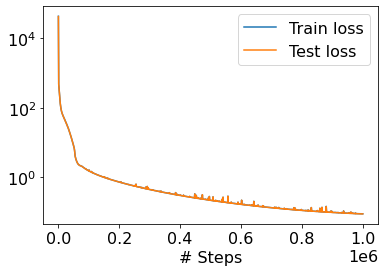

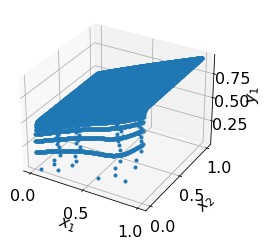

In [201]:

# Saving model at intermediate steps #
checkpointer = dde.callbacks.ModelCheckpoint(
     "model-DOW1-unification-008s-030323/model-DOW1-unification", verbose=0, save_better_only=True
 )

# Resampling PDE loss data points #
resampler = dde.callbacks.PDEResidualResampler(period=1000)

# Training the model # 
losshistory, trainstate = model.train(epochs = 1000000, callbacks = [variable, checkpointer, resampler],model_save_path='C/model-DOW1-unification-008s-030323') 

# Saving train and test error plots #
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)



In [206]:
# experimental data to validate the model results at unseen 0.05/s data #

valPoints = pd.read_excel('DOW1_030323.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=2,skiprows=range(155,298))

t_expt1 = np.array(valPoints["t"])
t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

gammadot1 = np.array(valPoints["shear rate"])
gammadot1 = gammadot1[:,np.newaxis]

shear_stress1 = np.array(valPoints["shear stress"])
shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


t_non_dim =  (t_expt1-time_min)/(del_time) #(t_expt1-0.5)/(600.0-0.5)
gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate) # (gammadot1-0.1)/(20.0-0.1)               

# using model to predict shear stress at a new shear rate #

test_data_set = np.hstack((gammadot_non_dim,t_non_dim))
test_shear_stress = model.predict(test_data_set) 

# making non-dimensional to dimensional
test_shear_stress1 = test_shear_stress*(del_stress) + stress_min


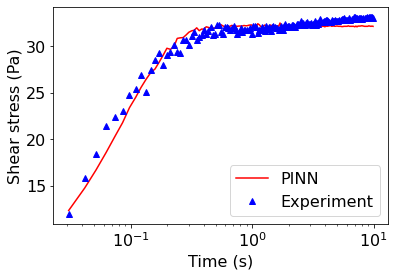

In [207]:
# plotting shear stress with time #

plt.figure()
plt.plot(t_expt1,test_shear_stress1, '-r', label='PINN')
plt.plot(t_expt1,shear_stress1, '^b', label='Experiment')
plt.legend()
plt.xscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Shear stress (Pa)')
plt.show()


In [205]:
# Restore the saved model with the smallest training loss - Run initial steps until compilation
# enter the correct model number
model.restore(f"model-DOW1-unification-008s-030323/model-DOW1-unification-999000.ckpt", verbose=1) 


Restoring model from model-DOW1-unification-008s-030323/model-DOW1-unification-999000.ckpt ...

INFO:tensorflow:Restoring parameters from model-DOW1-unification-008s-030323/model-DOW1-unification-999000.ckpt


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


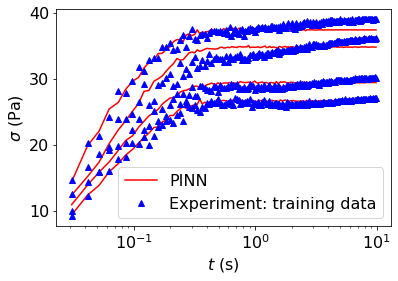

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


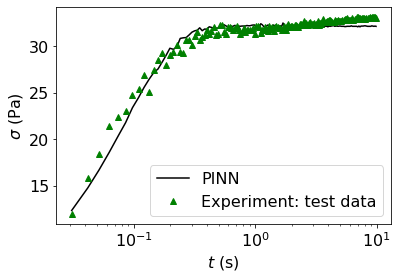

In [209]:
# Plotting training and test data for manuscript #

plt.rcParams.update({'font.size': 16})

for itrnew in range(0,5):
    if itrnew == 2:
        continue
    valPoints = pd.read_excel('DOW1_030323.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=itrnew,skiprows=range(155,298))
    
    t_expt1 = np.array(valPoints["t"])
    t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

    gammadot1 = np.array(valPoints["shear rate"])
    gammadot1 = gammadot1[:,np.newaxis]

    shear_stress1 = np.array(valPoints["shear stress"])
    shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


    t_non_dim =  (t_expt1-time_min)/(del_time)
    gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate)               

    # using model to predict shear stress at a new shear rate #
    test_data_set = np.hstack((gammadot_non_dim,t_non_dim))

    test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # Predicting shear stress 
    
    # making non-dimensional to dimensional
    test_shear_stress = test_shear_stress*(del_stress) + stress_min
    
    if itrnew == 0:
        plt.plot(t_expt1,test_shear_stress, '-r', label='PINN')
        plt.plot(t_expt1,shear_stress1, '^b', label='Experiment: training data')
    elif itrnew == 2:
        plt.plot(t_expt1,test_shear_stress, '-k', label='PINN: prediction '+str(itrnew+1)+'/s')
        plt.plot(t_expt1,shear_stress1, '^g', label='Experiment: test data '+str(itrnew+1)+'/s')
    else:
        plt.plot(t_expt1,test_shear_stress, '-r')
        plt.plot(t_expt1,shear_stress1, '^b')

plt.legend(loc='lower right')
plt.xscale('log')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('Shear_stress_trainingdata_DOW1_unification_1.eps',format='eps',bbox_inches='tight')
plt.show()

valPoints = pd.read_excel('DOW1_030323.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=2,skiprows=range(155,298))
    
t_expt1 = np.array(valPoints["t"])
t_expt1 = t_expt1[:,np.newaxis] # Converting to a column vector

gammadot1 = np.array(valPoints["shear rate"])
gammadot1 = gammadot1[:,np.newaxis]

shear_stress1 = np.array(valPoints["shear stress"])
shear_stress1 = shear_stress1[:,np.newaxis] # experiment value


t_non_dim =  (t_expt1-time_min)/(del_time) 
gammadot_non_dim = (gammadot1-shear_min)/(del_shear_rate)                

# using model to predict shear stress at a new shear rate #

test_data_set = np.hstack((gammadot_non_dim,t_non_dim))
test_shear_stress = model.predict(test_data_set,operator=lambda x,y: y[:,0:1]) # Predicting shear stress 
test_shear_stress = test_shear_stress*(del_stress) + stress_min

plt.plot(t_expt1,test_shear_stress, '-k', label='PINN')
plt.plot(t_expt1,shear_stress1, '^g', label='Experiment: test data')
    
plt.legend(loc='lower right')
plt.xscale('log')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('Shear_stress_testdata_DOW1_008s_unification_1.eps',format='eps',bbox_inches='tight')
plt.show()

Compiling model...
'compile' took 0.507090 s

Training model...

1500091   [2.03e-06, 2.45e-06, 2.48e-04]    [2.54e-06, 2.18e-06, 2.48e-04]    []  
INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000252
  Number of iterations: 1
  Number of functions evaluations: 18
1500109   [2.03e-06, 2.45e-06, 2.48e-04]    [2.54e-06, 2.18e-06, 2.48e-04]    []  

Best model at step 1500091:
  train loss: 2.52e-04
  test loss: 2.52e-04
  test metric: []

'train' took 1.818854 s

Saving loss history to C:\Users\pnagrani\loss.dat ...
Saving training data to C:\Users\pnagrani\train.dat ...
Saving test data to C:\Users\pnagrani\test.dat ...


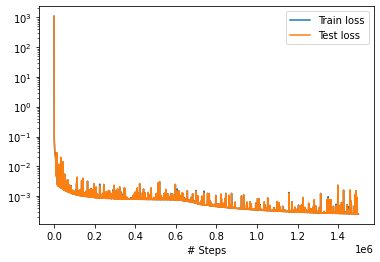

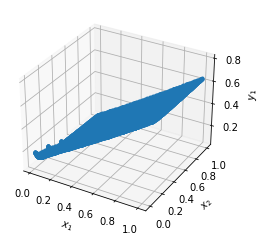

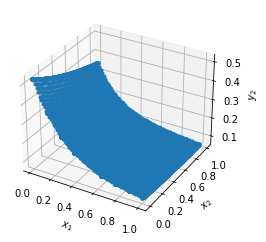

Compiling model...
'compile' took 0.630434 s

Training model...

Step      Train loss                        Test loss                         Test metric
1500109   [2.03e-06, 2.45e-06, 2.48e-05]    [2.54e-06, 2.18e-06, 2.48e-05]    []  

Best model at step 1500109:
  train loss: 2.93e-05
  test loss: 2.95e-05
  test metric: []

'train' took 0.628264 s



In [37]:
# If needed can perform further training using L-BFGS optimizer. We skipped as it did not improve the loss significantly #

model.compile("L-BFGS-B",
              loss_weights=[1,1,1e1],
              external_trainable_variables=[G, eta_s, k_plus, k_minus])

model.train_step.optimizer_kwargs = {'options': {'maxfun': 1e5, 'ftol': 1e-20, 'gtol': 1e-20,'eps': 1e-20, 'iprint': -1, 'maxiter': 1e5}}

variable = dde.callbacks.VariableValue([G, eta_s, k_plus, k_minus], period=10, filename="variables1-008s_DOWTC5622_LBFGSB.dat")
losshistory, trainstate = model.train(callbacks = [variable])
dde.saveplot(losshistory, trainstate, issave=True, isplot=True)

variable = dde.callbacks.VariableValue([G, eta_s, k_plus, k_minus], period=1, filename="dummy-4s.txt")
model.compile("adam", lr=0, external_trainable_variables=[G, eta_s, k_plus, k_minus])
losshistory2, train_state2 = model.train(epochs=0, callbacks=[variable], display_every=1)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


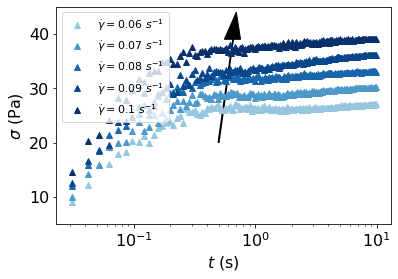

In [10]:
# Generating plot of experimental data - Not a part of PINN process #

plt.rcParams.update({'font.size': 16})
cmap = plt.colormaps['Blues']

for itr in range(0,5): 
    
    t_expt = []
    gammadot = []
    shear_stress = []
   
    startUpFlow = pd.read_excel('DOW1_030323.xlsx',header = None, names=['shear rate','t','shear stress'], sheet_name=itr, skiprows=range(155,298)) 
    # Reading data from sheet number - itr
    t_expt = np.array(startUpFlow["t"])
    shear_stress = np.array(startUpFlow["shear stress"])
    
    if itr==0:
        plt.plot(t_expt,shear_stress,color=cmap(itr+100), label='$\dot\gamma = 0.06~s^{-1}$',marker='^',linestyle = 'None')
    elif itr==1:
         plt.plot(t_expt,shear_stress,color=cmap(itr+150), label='$\dot\gamma = 0.07~s^{-1}$',marker='^',linestyle = 'None')
    elif itr==2:
         plt.plot(t_expt,shear_stress,color=cmap(itr+200), label='$\dot\gamma = 0.08~s^{-1}$',marker='^',linestyle = 'None')
    elif itr==3:
         plt.plot(t_expt,shear_stress,color=cmap(itr+230), label='$\dot\gamma = 0.09~s^{-1}$',marker='^',linestyle = 'None')
    else:
         plt.plot(t_expt,shear_stress,color=cmap(itr+300), label='$\dot\gamma = 0.1~s^{-1}$',marker='^',linestyle = 'None')

#lt.arrow(0.5,10,-0.1,15,fc="r",ec='r',head_width = 0.2,head_length=0.2,width=0.02)    
plt.arrow(0.5,20,0.2,24, fc="k",ec='k',width=0.01,length_includes_head='True',head_length=5,head_width=0.2)
plt.legend(loc='upper left',prop={'size': 11})
plt.xscale('log')
plt.ylim([5, 45])
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.savefig('Shear_stress_experiment_DOW1_030323.eps',format='eps',bbox_inches='tight')
plt.show()

        
       


Consistency Index: 104.02946042671768
Power law exponenet: 0.8844988835126537
R squared: 0.9965229133378861


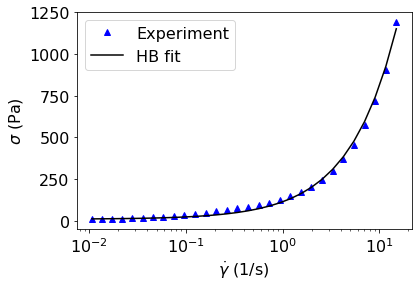

In [22]:
# Generating plot of experimental data - Not a part of PINN process #
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def hb_func(x,k,n):
    return 9.5 + k*(x**n) 

plt.rcParams.update({'font.size': 16})
cmap = plt.colormaps['Blues']
   
startUpFlow = pd.read_excel('DOW1_030323.xlsx',header = None, names=['shear rate','shear stress'], sheet_name=6)#, skiprows=range(0,10))
gamma_expt = np.array(startUpFlow["shear rate"])
shear_stress = np.array(startUpFlow["shear stress"])

popt, pcov = curve_fit(hb_func,gamma_expt,shear_stress)

k = popt[0]
print('Consistency Index: ' + str(k))
n = popt[1]
print('Power law exponenet: ' + str(n))

fit_y = hb_func(gamma_expt,k,n)
r2 = r2_score(shear_stress, fit_y)
print('R squared: ' + str(r2))

plt.plot(gamma_expt,shear_stress,'^b',label='Experiment')
plt.plot(gamma_expt,fit_y,'-k',label='HB fit')
plt.xscale('log')
plt.xlabel(r'$\dot\gamma$ (1/s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.legend(loc='upper left',prop={'size': 16})
plt.savefig('DOW1_FlowCurve_HBFit.eps',format='eps',bbox_inches='tight')
plt.show()
